In [57]:
import sys
!{sys.executable} -m pip install pandas matplotlib yfinance numpy google-cloud-bigquery pyarrow pandas-gbq

import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf # https://github.com/ranaroussi/yfinance
import numpy as np
from google.cloud import bigquery as bq
from google.oauth2 import service_account
from datetime import date

In [2]:
# Import data
green_stocks = pd.read_csv('./data/green_stocks.csv')
green_stocks.head()

,Name,Ticker,Category,ETF
0,Brookfield Renewable Partners,BEP,power_hydro,NaN
1,General Electric,GE,power_wind,NaN
2,NextEra Energy Partners,NEP,power_wind,NaN
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,NaN
4,Vestas Wind Systems,VWDRY,power_wind,NaN


<AxesSubplot:>

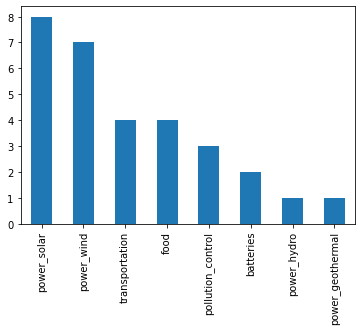

In [3]:
# Understand distribution of stock data
green_stocks['Category'].value_counts().plot(kind='bar')

<AxesSubplot:>

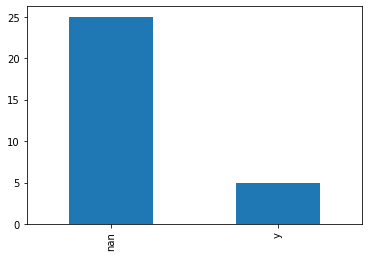

In [4]:
green_stocks['ETF'].value_counts(dropna=False).plot(kind='bar')

In [5]:
# Example Yahoo Finance query based on ticker symbol of 'BEP'
BEP = yf.Ticker('BEP')

In [6]:
BEP.info['longBusinessSummary']

'Brookfield Renewable Partners L.P. owns a portfolio of renewable power generating facilities primarily in North America, Colombia, Brazil, Europe, India, and China. The company generates electricity through hydroelectric, wind, solar, distributed generation, pumped storage, cogeneration, and biomass sources. Its portfolio consists of approximately 19,000 megawatts of installed capacity. Brookfield Renewable Partners Limited operates as the general partner of Brookfield Renewable Partners L.P. The company was formerly known as Brookfield Renewable Energy Partners L.P. and changed its name to Brookfield Renewable Partners L.P. in May 2016. Brookfield Renewable Partners L.P. was founded in 1999 and is based in Toronto, Canada.'

In [7]:
BEP.info['website']

'http://www.bep.brookfield.com'

In [8]:
# Get stock data for all green stocks

stock_descriptions = []
stock_websites = []

def get_stock_description(ticker):
    stock = yf.Ticker(ticker)
    # Descriptive information
    try:
        description = stock.info['longBusinessSummary']
        website = stock.info['website']
    except:
        description = np.nan
        website = np.nan
        print(f'No stock with {ticker} ticker symbol...')
    stock_descriptions.append(description)
    stock_websites.append(website)

In [9]:
green_stocks['Ticker'].apply(get_stock_description)

green_stocks = pd.concat([green_stocks,pd.Series(stock_descriptions, name='Description')], axis=1).copy()
green_stocks = pd.concat([green_stocks,pd.Series(stock_websites, name='Website')], axis=1).copy()

No stock with FAN ticker symbol...
No stock with VSLR ticker symbol...
No stock with TAN ticker symbol...
No stock with EVX ticker symbol...
No stock with PZD ticker symbol...
No stock with DRIV ticker symbol...


In [10]:
green_stocks

,Name,Ticker,Category,ETF,Description,Website
0,Brookfield Renewable Partners,BEP,power_hydro,NaN,Brookfield Renewable Partners L.P. owns a port...,http://www.bep.brookfield.com
1,General Electric,GE,power_wind,NaN,General Electric Company operates as a high-te...,http://www.ge.com
2,NextEra Energy Partners,NEP,power_wind,NaN,"NextEra Energy Partners, LP acquires, owns, an...",http://www.investor.nexteraenergypartners.com
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,NaN,"Siemens Gamesa Renewable Energy, S.A., togethe...",http://www.siemensgamesa.com
4,Vestas Wind Systems,VWDRY,power_wind,NaN,"Vestas Wind Systems A/S designs, manufactures,...",http://www.vestas.com
5,First Trust Global Wind Energy ETF,FAN,power_wind,y,NaN,NaN
6,First Solar,FSLR,power_solar,NaN,"First Solar, Inc. provides photovoltaic (PV) s...",http://www.firstsolar.com
7,JinkoSolar Holding,JKS,power_solar,NaN,"JinkoSolar Holding Co., Ltd., together with it...",http://www.jinkosolar.com
8,Sunpower,SPWR,power_solar,NaN,SunPower Corporation delivers solar solutions ...,http://us.sunpower.com
9,Enphase Energy,ENPH,power_solar,NaN,"Enphase Energy, Inc., together with its subsid...",http://www.enphase.com


In [11]:
# Clean up stocks with missing description / websites (indicating no data in Yahoo Finance)
# These are mostly ETFs
green_stocks = green_stocks.dropna(subset=['Description']).copy()
green_stocks.drop(labels=['ETF'], axis=1, inplace=True)
green_stocks.head()

,Name,Ticker,Category,Description,Website
0,Brookfield Renewable Partners,BEP,power_hydro,Brookfield Renewable Partners L.P. owns a port...,http://www.bep.brookfield.com
1,General Electric,GE,power_wind,General Electric Company operates as a high-te...,http://www.ge.com
2,NextEra Energy Partners,NEP,power_wind,"NextEra Energy Partners, LP acquires, owns, an...",http://www.investor.nexteraenergypartners.com
3,Siemens Gamesa Renewable Energy,GCTAY,power_wind,"Siemens Gamesa Renewable Energy, S.A., togethe...",http://www.siemensgamesa.com
4,Vestas Wind Systems,VWDRY,power_wind,"Vestas Wind Systems A/S designs, manufactures,...",http://www.vestas.com


In [12]:
# Upload green stocks dataframe to BigQuery

# Credentials, settings
project_id, dataset, table_name = "pme-green-stocks", "pme_green_stocks", "green_stock_descriptions"

green_stocks.to_gbq( f"{dataset}.{table_name}", project_id = project_id, if_exists = 'replace')
print("Write to GBQ complete.")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=8kuWllLIRDMf0VGgYqjTqvpC8itjMj&prompt=consent&access_type=offline
Enter the authorization code: 4/1AX4XfWiDnCVPjn6y_sDQtaUGRAslB6cPLUTpXrtaKwsxHunnMNGLHn-f004


Unable to create credentials directory.


Write to GBQ complete.


In [117]:
# Load S&P 500 open/close price data into new table for max/min dates of green stocks

def get_high_lows(ticker):
    try:
        data = yf.download(  # or pdr.get_data_yahoo(...
                # tickers list or string as well
                tickers = ticker,

                # use "period" instead of start/end
                # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                # (optional, default is '1mo')
                period = "5y",

                # fetch data by interval (including intraday if period < 60 days)
                # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                # (optional, default is '1d')
                interval = "1mo",

                # group by ticker (to access via data['SPY'])
                # (optional, default is 'column')
    #             group_by = 'ticker',

                # adjust all OHLC automatically
                # (optional, default is False)
                auto_adjust = True, 
                # This takes into account dividends paid out, no need to calculate this on our own

                # download pre/post regular market hours data
                # (optional, default is False)
                prepost = False,

                # use threads for mass downloading? (True/False/Integer)
                # (optional, default is True)
                threads = True,

                # proxy URL scheme use use when downloading?
                # (optional, default is None)
                proxy = None
            )
        data['Ticker'] = ticker

        data.dropna(how='any',subset=['Open', 'High', 'Low', 'Close', 'Volume'],inplace=True)
        
        return data
    except:
        print("ERROR")

stock_hl = get_high_lows("VFTAX")

[*********************100%***********************]  1 of 1 completed


In [118]:
stock_hl

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2019-03-01,24.975252,25.456656,24.416823,25.187069,0.0,VFTAX
2019-04-01,25.560017,26.371446,25.560017,26.361788,0.0,VFTAX
2019-05-01,26.178252,26.400429,24.680971,24.680971,0.0,VFTAX
2019-06-01,24.555391,26.439066,24.555391,26.323147,0.0,VFTAX
2019-07-01,26.662595,27.350974,26.662595,26.972851,0.0,VFTAX
2019-08-01,26.730464,26.730464,25.663960,26.439600,0.0,VFTAX
2019-09-01,26.216606,27.157068,26.216606,26.798334,0.0,VFTAX
2019-10-01,26.573480,27.732234,26.086608,27.654335,0.0,VFTAX
2019-11-01,27.917248,28.900730,27.917248,28.793617,0.0,VFTAX


In [119]:
for stock in green_stocks.Ticker.to_list():
    data = get_high_lows(stock)
    stock_hl = pd.concat([stock_hl, data])
    
stock_hl

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2019-03-01,24.975252,25.456656,24.416823,25.187069,0.0,VFTAX
2019-04-01,25.560017,26.371446,25.560017,26.361788,0.0,VFTAX
2019-05-01,26.178252,26.400429,24.680971,24.680971,0.0,VFTAX
2019-06-01,24.555391,26.439066,24.555391,26.323147,0.0,VFTAX
2019-07-01,26.662595,27.350974,26.662595,26.972851,0.0,VFTAX
...,...,...,...,...,...,...
2021-07-01,29.830000,30.500000,26.719999,27.900000,676300.0,LSF
2021-08-01,27.920000,28.570000,17.375000,19.930000,1674900.0,LSF
2021-09-01,19.590000,21.150000,16.900000,19.080000,947700.0,LSF


In [123]:
# Earliest date for each stock
stock_hl['Date'] = stock_hl.index
stock_hl.groupby('Ticker')['Date'].min()

Ticker
AZRE    2016-11-01
BEP     2016-11-01
BLDP    2016-11-01
BRLXF   2016-11-01
ENPH    2016-11-01
F       2016-11-01
FCEL    2016-11-01
FNEC    2016-11-01
FSLR    2016-11-01
FTEK    2016-11-01
GCTAY   2016-11-01
GE      2016-11-01
GM      2016-11-01
INGR    2016-11-01
JKS     2016-11-01
LSF     2020-10-01
MNHVF   2016-11-01
NEP     2016-11-01
ORA     2016-11-01
RUN     2016-11-01
SPWR    2016-11-01
TSLA    2016-11-01
UNFI    2016-11-01
VFTAX   2019-03-01
VWDRY   2016-11-01
Name: Date, dtype: datetime64[ns]

In [124]:
# Drop all entries earlier than earliest date of our index fund (2019-03-01)
stock_hl = stock_hl[stock_hl['Date'] >= '2019-03-01']

In [126]:
# Check the results
stock_hl.groupby('Ticker')['Date'].min()

Ticker
AZRE    2019-03-01
BEP     2019-03-01
BLDP    2019-03-01
BRLXF   2019-03-01
ENPH    2019-03-01
F       2019-03-01
FCEL    2019-03-01
FNEC    2019-03-01
FSLR    2019-03-01
FTEK    2019-03-01
GCTAY   2019-03-01
GE      2019-03-01
GM      2019-03-01
INGR    2019-03-01
JKS     2019-03-01
LSF     2020-10-01
MNHVF   2019-03-01
NEP     2019-03-01
ORA     2019-03-01
RUN     2019-03-01
SPWR    2019-03-01
TSLA    2019-03-01
UNFI    2019-03-01
VFTAX   2019-03-01
VWDRY   2019-03-01
Name: Date, dtype: datetime64[ns]

In [121]:
# Upload stock high/low table to BigQuery for further analysis and visualization

# Credentials, settings
project_id, dataset, table_name = "pme-green-stocks", "pme_green_stocks", "high_low"

stock_hl.to_gbq( f"{dataset}.{table_name}", project_id = project_id, if_exists = 'replace')
print("Write to GBQ complete.")

Write to GBQ complete.
